In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
import json
import shutil#doing copypast or move sth from somewhere

In [1]:
!pip install pylabel # the library that can convert coco to yolo
!pip install ultralytics #  yolo models would be called by this ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 kB 23.3 MB/s eta 0:00:00


In [9]:
splits = ["train","test","valid"]

path = "SARSCOPE/"
os.mkdir(path) #making a folder by this commend
for item in splits:
    try:
        os.mkdir(path+item)
    except OSE as error:
        print(error)

FileExistsError: [Errno 17] File exists: 'SARSCOPE/'

In [19]:
#coco 's img always saved as a json but yolo's img need to be saved as a text
def extract_image(source_path,dst_path):
    if not os.path.exists(source_path):
        os.mkdir(dst_path)
    image_path = glob.glob(source_path+"/*.jpg")
    for path in image_path:
        shutil.copy(path,dst_path)

In [21]:
#coying img to train in the output
source_path = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/train"
dst_path = "/kaggle/working/SARSCOPE/train/images"
extract_image(source_path,dst_path)

In [22]:
#coying img to test in the output
source_path = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test"
dst_path = "/kaggle/working/SARSCOPE/test/images"
extract_image(source_path,dst_path)

In [25]:
#coying img to valid in the output
source_path = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid"
dst_path = "/kaggle/working/SARSCOPE/valid/images"
extract_image(source_path,dst_path)

In [29]:
#now the label that is in json in coco has to be converted into the text which is useable for yolo label
#label=>text
from pylabel import importer
def conver_cocotoYolo(source_path,dst_path):
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)
    json_file=glob.glob(source_path+"/*.json")
    dataset=importer.ImportCoco(json_file[0], path_to_images=source_path, name="SARscope")
    dataset.export.ExportToYoloV5(dst_path)

In [30]:
#making text label for YOLO for train folder
source_path = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/train"
dst_path = "/kaggle/working/SARSCOPE/train/label"
conver_cocotoYolo(source_path,dst_path)

/opt/conda/lib/python3.10/site-packages/pylabel/importer.py:127: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("", inplace=True)
/opt/conda/lib/python3.10/site-packages/pylabel/exporter.py:551: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  yolo_dataset.ann_bbox_xmin = yolo_dataset.ann_bbox_xmin.replace(
/opt/conda/lib/python3.10/site-packages/pylabel/exporter.py:554: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future beha

In [31]:
#making text label for YOLO for test folder
source_path = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test"
dst_path = "/kaggle/working/SARSCOPE/test/label"
conver_cocotoYolo(source_path,dst_path)

Exporting YOLO files...: 100%|██████████| 672/672 [00:01<00:00, 443.78it/s]


In [36]:
#making text label for YOLO for valid folder
source_path = "/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/valid"
dst_path = "/kaggle/working/SARSCOPE/valid/label"
conver_cocotoYolo(source_path,dst_path)

Exporting YOLO files...: 100%|██████████| 1346/1346 [00:03<00:00, 365.60it/s]


In [39]:
#time to train 
#!mv /kaggle/working/SARSCOPE/train/dataset.yaml /kaggle/working/SARSCOPE

!mv /kaggle/working/SARSCOPE/train/dataset.yaml /kaggle/working/SARSCOPE

mv: cannot stat '/kaggle/working/SARSCOPE/train/dataset.yaml': No such file or directory


In [34]:
!rm /kaggle/working/SARSCOPE/valid/dataset.yaml #removing yaml from valid
!rm /kaggle/working/SARSCOPE/test/dataset.yaml #removing yaml from test

In [40]:
config_file_template = '''
train: /kaggle/working/SARSCOPE/train/images
val: /kaggle/working/SARSCOPE/valid/images
test: ../SaRscope/test/images

nc: 2
names: ['background','ship']
'''

with open('dataset.yaml', 'w') as f:
    f.write(config_file_template)

In [41]:
import yaml 
with open('/kaggle/working/dataset.yaml', 'r') as f:
    file_path=yaml.safe_load(f)
print(file_path)

{'train': '../SaRscope/train/images', 'val': '../SaRscope/valid/images', 'test': '../SaRscope/test/images', 'nc': 2, 'names': ['background', 'ship']}


In [42]:
from ultralytics import YOLO
model = YOLO('yolov8n.yaml').load('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 137MB/s]

Transferred 355/355 items from pretrained weights


In [43]:
model.train(data="dataset.yaml",epochs=15,imgsz=640,device=0)

Ultralytics YOLOv8.2.18 🚀 Python-3.10.13 torch-2.1.2+cpu 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [44]:
model.export()

Ultralytics YOLOv8.2.18 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from 'yolov8n.yaml' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (0.0 MB)

TorchScript: starting export with torch 2.1.2+cpu...
TorchScript: export success ✅ 2.4s, saved as 'yolov8n.torchscript' (12.5 MB)

Export complete (4.1s)
Results saved to /kaggle/working
Predict:         yolo predict task=detect model=yolov8n.torchscript imgsz=640  
Validate:        yolo val task=detect model=yolov8n.torchscript imgsz=640 data=None  
Visualize:       https://netron.app


'yolov8n.torchscript'


image 1/1 /kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/P0132_1200_2000_9600_10400_png.rf.06c692c12f113e506f4ef94618a66892.jpg: 640x640 1 0, 129.1ms
Speed: 7.2ms preprocess, 129.1ms inference, 3064.4ms postprocess per image at shape (1, 3, 640, 640)


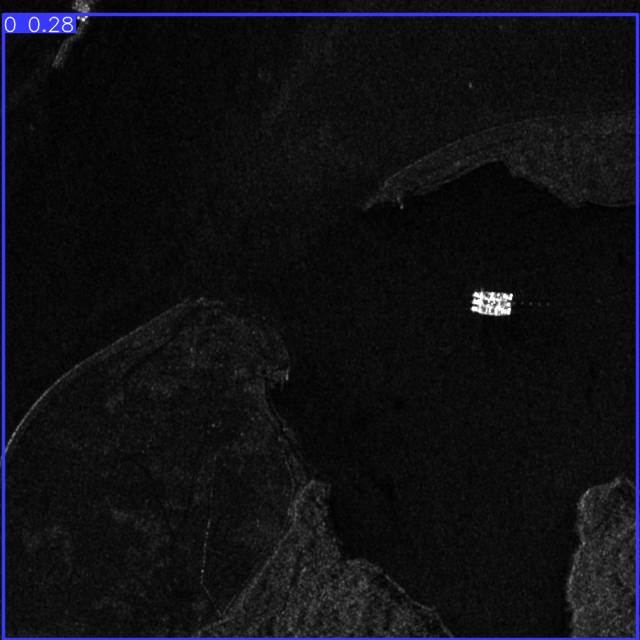

In [45]:
from PIL import Image
test_images=glob.glob("/kaggle/input/sarscope-unveiling-the-maritime-landscape/SARscope/test/*.jpg")
results=model(test_images[4],stream=False)

res=results[0].plot()
Image.fromarray(res)

In [46]:
test_model=YOLO("/kaggle/working/runs/detect/train/weights/best.pt")
results=test_model(test_images[:4],stream=False)
for i in range(4):
    res=results[i].plot()
    display(Image.fromarray(res))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/detect/train/weights/best.pt'

In [47]:
model.export(format='openvino') 

Ultralytics YOLOv8.2.18 🚀 Python-3.10.13 torch-2.1.2+cpu CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'yolov8n.yaml' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (0.0 MB)
requirements: Ultralytics requirement ['openvino>=2024.0.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.7/38.7 MB 91.6 MB/s eta 0:00:00a 0:00:01m

requirements: AutoUpdate success ✅ 13.7s, installed 1 package: ['openvino>=2024.0.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2024.1.0-15008-f4afc983258-releases/2024/1...
OpenVINO: export success ✅ 18.2s, saved as 'yolov8n_openvino_model/' (12.3 MB)

Export complete (19.7s)
Results saved to /kaggle/working
Predict:         yolo predict task=detect model=yolov8n_openvino_model imgsz=640  
Validate:        yolo val task=detect model=yolov8n_openvino_model imgsz=640 data=None  
Visualize:       https://netron.app


'yolov8n_openvino_model'